# Project Statement:

The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
Computer vision methods can be used to determine age of a person from a photo
The task then is to build and evaluate a model for verifying people's age
To start working on the task, you'll have a set of photographs of people with their ages indicated.


## Initialization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
data_labels = pd.read_csv("/datasets/faces/labels.csv")
data_images = "/datasets/faces/final_files"

## EDA

In [3]:
images_list = sorted(os.listdir(data_images))
len(images_list)

7591

In [4]:
images_list[:5]

['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg']

In [5]:
data_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
print(data_labels.shape)
data_labels.info()

(7591, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
data_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
data_labels['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

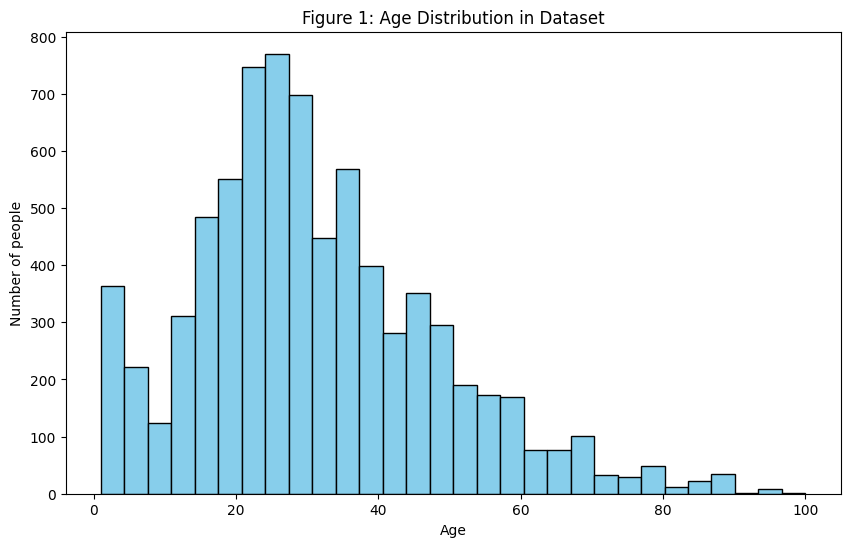

In [9]:
plt.figure(figsize=(10,6))
plt.hist(data_labels['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of people')
plt.title('Figure 1: Age Distribution in Dataset')
plt.show()

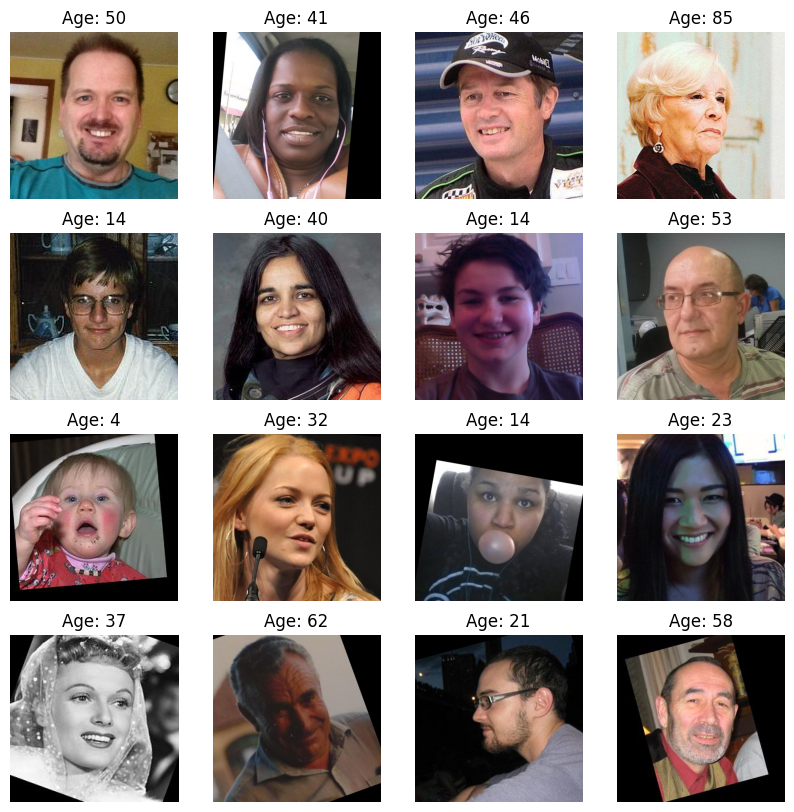

In [10]:
# Print 10-15 photos for different ages on the screen to get an overall impression of the dataset

sample_data = data_labels.sample(16, random_state = 12345)

plt.figure(figsize=(10,10))
for i, row in enumerate(sample_data.itertuples(), 1):
    img_path = f"{data_images}/{row.file_name}"
    img = Image.open(img_path)
    plt.subplot(4,4,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Age: {row.real_age}")
plt.show()

### Findings

<div><span style = color:blue>  Comments: 

After loading the dataset and running some basic EDA, we can graph the distribution to get an overall impression of the ages. We see the majority of the dataset lies within ages 20-40 (give or take) and the least number of people (data) for ages 80 and above. We can also look through some of the images from the image file since looking through all would take too much space and time. Looking at 16 images at random, we get a good mix of pool from age 4 to age 85. As we take a futher look we notice there are more people within the 30-50 age group than the other groups. This is good since it is clearly easier to differntiate someone who is either really young or really old as opposed to those who are within the middle-aged group. Additionally, there are many photos that are not centered and all the facial features are not easily readible by human eyes. As such, it is fantastic to have computer vision with such cases where the individual's faces are sideways or we're working off a black and white photo.</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [12]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    data_labels = pd.read_csv("/datasets/faces/labels.csv")
    data_images = "/datasets/faces/final_files"
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale = 1./255)
    
    train_gen = datagen.flow_from_dataframe(
        dataframe = data_labels,
        directory = data_images,
        x_col='file_name',
        y_col='real_age',
        class_mode = 'raw',
        batch_size=16,
        target_size = (150,150),
        subset='training',
        seed=12345)

    return train_gen

In [13]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    data_labels = pd.read_csv("/datasets/faces/labels.csv")
    data_images = "/datasets/faces/final_files"
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale = 1./255)
    
    test_gen = datagen.flow_from_dataframe(
        dataframe = data_labels,
        directory = data_images,
        x_col='file_name',
        y_col='real_age',
        class_mode = 'raw',
        batch_size=16,
        target_size = (150,150),
        subset='test',
        seed=12345)
    
    return test_gen

In [14]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [16]:

# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921

Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035

Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454

Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481

Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192

Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332

Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359

Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239

Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529

Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629

Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866

Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591

Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467

Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401

Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841

Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304

Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419

Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226

Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908

Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Good script and results.

</div>

## Conclusions

<div> <span style = color:blue> Comments - Conclusion:
This is a very complex project that extends the understanding of Machine Learning into practical applcations such as Computer Vision. Particularly, we built a model to take into account a person's age based on their photos, noting that not all photos were perfect. In fact many photos were photos of photos rather than photos of the individual, many images were not very clear or had hidden features. Using human eyesight, it can be very subjective to decipher if someone appears 21+ simply from a photo taken from a camera in a store. The angles and lighting and other features can play a critical role in human eyesight. As such, training a computer vision model with over 7K images of varying ages can really help humans make better decisions in general but in this case whether a customer is over the age of 21, when buying alcohol. In terms of the model, it was run on a GPU platform previously so the output was already provided to us. From this output, we understand the model took into account 20 epochs of training and over time we see a drop in error (MAE), which means the model learns with every iteration. One important note was that the Validation MAE was double the Training MAE but nevertheless it decreased and then stablized. The difference in error between the Training and Validation set means the model can be further trained by fine-tuning some parameters, applying augmentation, adding in more layer or dropouts, etc. Overall, this was a great project and I am excited to learn about advanced technologies such as face recognition and identification.

</div>

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training